## Стрельникова Полина Александровна

 <h1 align = "center"> ПОСТРОЕНИЕ ЛИНЕЙНОЙ И ПОЛИНОМИАЛЬНОЙ РЕГРЕССИИ </h1>

In [35]:
import numpy as np

import scipy.linalg as sla

import matplotlib.pyplot as plt

import copy

import math

def my_det(X):
    width = len(X[0])
    height = len(X)
    det = 1
    try:
        width == height
    except ValueError as e:
        print(e)
    i = 0
    while i < (height - 1):
        if X[i][i] > 0:
            for k in range(i + 1, height):
                if X[k][i] > 0:
                    div = X[k][i] / X[i][i]
                    for j in range(i, width):
                        X[k][j] -= X[i][j] * math.fabs(div)
                elif X[k][i] < 0:
                    div = X[k][i] / X[i][i]
                    for j in range(i, width):
                        X[k][j] += X[i][j] * math.fabs(div)
        elif X[i][i] < 0:
            for k in range(i + 1, height):
                if X[k][i] > 0:
                    div = X[k][i] / X[i][i]
                    for j in range(i, width):
                        X[k][j] += X[i][j] * math.fabs(div)
                elif X[k][i] < 0:
                    div = X[k][i] / X[i][i]
                    for j in range(i, width):
                        X[k][j] -= X[i][j] * math.fabs(div)
        else:
            flag = 0
            for s in range(i, height):
                if X[s][i] != 0:
                    sub = copy.copy(X[i])
                    for n in range(i, width):
                        X[i][n] = X[s][n]
                        X[s][n] = sub[n]
                    flag = 1
                    break
            if flag == 1:
                i -= 1
        i += 1
    for h in range(height):
        det *= X[h][h]

    return det

Попробуем самостоятельно реализовать функцию, которая считает определитель у матрицы. В pandas и numpy функции гораздо более оптимизированные и работают гораздо быстрее. Проверим программу на работоспособность, а затем визуализируем наше предположение.

In [36]:
X = np.array([[0,0,1], [0,1,0], [1,0,0]])
print(X)
print(my_det(X))

[[0 0 1]
 [0 1 0]
 [1 0 0]]
1


10.2 µs ± 21.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
48.4 µs ± 58 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
84.8 µs ± 2.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
154 ms ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
819 µs ± 59.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.4 s ± 892 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


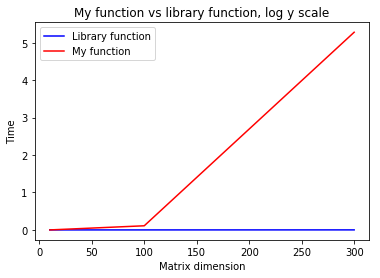

In [37]:
lib_times = []
my_times = []
dimensions = [10, 100, 300]
for dim in dimensions:
    A = np.random.rand(dim, dim)
    res_lib = %timeit -o sla.det(A)
    lib_times.append(res_lib.best)
    res_my = %timeit -o my_det(A)
    my_times.append(res_my.best)    

plt.plot(dimensions, lib_times, color='blue', label='Library function')
plt.plot(dimensions, my_times, color='red', label='My function')
plt.title('My function vs library function, log y scale')
plt.ylabel('Time')
plt.xlabel('Matrix dimension')
plt.legend()

И логарифмический масштаб

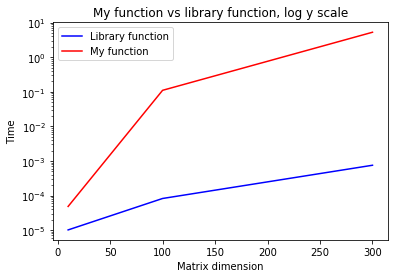

In [38]:
plt.semilogy(dimensions, lib_times, color='blue', label='Library function')
plt.semilogy(dimensions, my_times, color='red', label='My function')
plt.title('My function vs library function, log y scale')
plt.ylabel('Time')
plt.xlabel('Matrix dimension')
plt.legend()

Библиотечная функция гораздо быстрее! Теперь попробуем построить линейную регрессию

### Метод наименьших квадратов:

Рассмотрим систему уравнений $Xa = y$, в которой $a$ --- столбец неизвестных. Её можно переписать в векторном виде
$$x_1 a_1 + x_2 a_2 + \ldots + x_k a_k = y,$$
где $x_1,\ldots,x_n$ --- столбцы матрицы $X$. Таким образом, решить исходную систему означает найти линейную комбинацию векторов $x_1,\ldots,x_n$, равную правой части. Но что делать, если такой линейной комбинации не существует? Геометрически это означает, что вектор $y$ не лежит в подпространстве $U = \langle x_1,\ldots, x_k\rangle$. В этом случае мы можем найти *псевдорешение*: вектор коэффициентов $\hat{a}$, для которого линейная комбинация $x_1 \hat{a}_1 + x_2 \hat{a}_2 + \ldots + x_k \hat{a}_k$ хоть и не равна в точности $y$, но является наилучшим приближением --- то есть ближайшей к $y$ точкой $\hat{y}$ подпространства $U$ (иными словами, ортогональной проекцией $y$ на это подпростанство). Итак, цель наших исканий можно сформулировать двумя эквивалентными способами:

1. Найти вектор $\hat{a}$, для которого длина разности $|X\hat{a} - y|$ минимальна (отсюда название "метод наименьших квадратов");
2. Найти ортогональную проекцию $\hat{y}$ вектора $y$ на подпространство $U$ и представить её в виде $X\hat{a}$.

Далее мы будем предполагать, что векторы $x_1,\ldots,x_n$ линейно независимы (если нет, то сначала имеет смысл выделить максимальную линейно независимую подсистему).

Проекция вектора $y$ на подпространство $U = \langle x_1,\ldots, x_k\rangle$, записывается в виде
$$\hat{y} = X\left(X^TX\right)^{-1}X^Ty,$$
и, соответственно, искомый вектор $\hat{a}$ равен
$$\hat{a} = \left(X^TX\right)^{-1}X^Ty.$$

Теперь проговорим общую постановку задачи линейной регрессии. У нас есть $k$ переменных $x_1,\ldots,x_k$ ("регрессоров"), через которые мы хотим выразить "объясняемую переменную" $y$:
$$y = a_1x_1 + a_2x_2 + \ldots + a_kx_k$$
Значения всех переменных мы измерили $n$ раз (у $n$ различных объектов,  в $n$ различных моментов времени - это зависит от задачи). Подставим эти данные в предыдущее равенство:
$$\begin{pmatrix}
y_1\\ y_2 \\ \vdots \\ y_n
\end{pmatrix} = 
a_1\begin{pmatrix}
x_{11} \\ x_{21} \\ \vdots \\ x_{n1} \end{pmatrix} + a_2\begin{pmatrix}
x_{12} \\ x_{22} \\ \vdots \\ x_{n2} \end{pmatrix} + \ldots + a_k\begin{pmatrix}
x_{1k} \\ x_{2k} \\ \vdots \\ x_{nk} \end{pmatrix}$$
(здесь $x_{ij}$ - это значение $j$-го признака на $i$-м измерении). Это удобно переписать в матричном виде:
$$\begin{pmatrix}
x_{11} & x_{12} & \ldots & x_{1k}\\
x_{21} & x_{22} & \ldots & x_{2k}\\
\dots & \dots & \dots & \dots\\
x_{n1} & x_{n2} & \ldots & x_{nk}
\end{pmatrix} \cdot
\begin{pmatrix}
a_1 \\ a_2 \\ \vdots \\ a_k
\end{pmatrix} = 
\begin{pmatrix}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{pmatrix}$$
или коротко $Xa = y$. Поскольку на практике эта система уравнений зачастую не имеет решения (ибо зависимости в жизни редко бывают действительно линейными), методом наименьших квадратов ищется псевдорешение.

In [39]:
data_train = np.loadtxt('C:/Users/rowil/Downloads/train.txt', delimiter=','
data_test = np.loadtxt('C:/Users/rowil/Downloads/test.txt', delimiter=',') 
X_train = data_train[:,0] 
y_train = data_train[:,1]
X_test = data_test[:,0]
y_test = data_test[:,1]

In [40]:
X = np.array([np.ones(X_train.shape[0]), X_train]).T
approx = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_train) 
y_hat = np.dot(approx, X.T) 

Изобразим результат на графике:

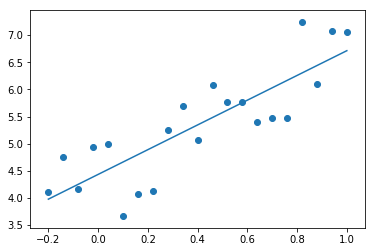

In [41]:
plt.plot(X_train, y_hat) 
plt.scatter(X_train, y_train) 
plt.show()

Попробуем поиграться со степенями многочлена и посмотреть на результаты, а также посчитать среднеквадратичное отклонение:

0.39619152773843663
0.2697696706251704
0.2665588946468781
0.261994027980508
0.23852372607953973
0.22836606999274628
0.2227696320438727
0.22044089364232974
0.2191016406602476
0.2004947242696863


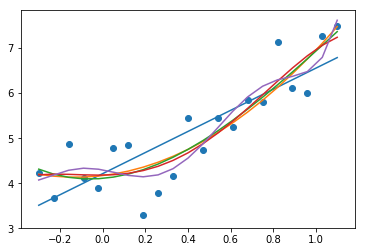

In [42]:
XS = np.ones(X_test.size).reshape(-1, 1)
for i in range (1, 11):
    XS = np.concatenate((XS, X_test.reshape(-1, 1)**i), axis = 1)
    approx = np.dot(np.dot(np.linalg.inv(np.dot(XS.T, XS)), XS.T), y_test)
    y_hat = np.dot(approx, XS.T)
    meandev = np.sum((y_hat - y_test)**2)/(len(y_test)) 
    print(meandev)
    if (i <= 4 or i == 6):
        plt.plot(X_test, y_hat)

plt.scatter(X_test, y_test)
plt.show()

Казалось бы, чем больше степень, тем более сложным будет многочлен и тем лучше он будет приближать нашу функцию. Однако мы видим ошибки на тестовых данных при $k > 10$. Это - переобучение, функция приспособлена для конкретного набора данных, а на других - ломается

0.39619152773843663
0.2697696706251704
0.2665588946468781
0.261994027980508
0.23852372607953973
0.22836606999274628
0.2227696320438727
0.22044089364232974
0.2191016406602476
0.2004947242696863
0.11620240087779839
0.08652648160030085
0.0888876929413826
5.714267546065537
4707.264093213806
184.96973921460483
55.12137225111602
35.079968483612234


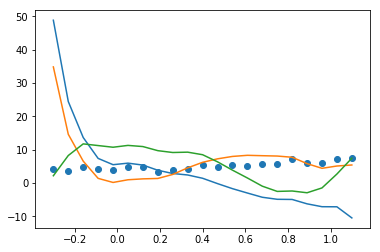

In [43]:
XS = np.ones(X_test.size).reshape(-1, 1)
for i in range (1, 19):
    XS = np.concatenate((XS, X_test.reshape(-1, 1)**i), axis = 1)
    approx = np.dot(np.dot(np.linalg.inv(np.dot(XS.T, XS)), XS.T), y_test)
    y_hat = np.dot(approx, XS.T)
    meandev = np.sum((y_hat - y_test)**2)/(len(y_test)) 
    print(meandev)
    if (i > 15):
        plt.plot(X_test, y_hat)

plt.scatter(X_test, y_test)
plt.show()
#переобучение

Теперь опробуем полиномиальную регрессию. Загрузим файл ``flats_moscow_mod.txt`` из открытого доступа. В нём содержатся данные о квартирах в Москве. Каждая строка содержит шесть характеристик некоторой квартиры, разделённые знаками табуляции; в первой строке записаны кодовые названия характеристик.

Оценим качество приближения, вычислив среднеквадратическую ошибку и найдя регрессионные коэффициенты. 

In [44]:
data_flats = np.loadtxt('C:/Users/rowil/Downloads/flats_moscow_mod.txt', skiprows = 1, delimiter='\t')
price = data_flats[:,0]
characts = data_flats[:,1:]
ones_mat = np.array(np.mat((np.ones(len(characts))))).T
characts = np.concatenate((characts, ones_mat), axis = 1)
koeffs = np.dot(np.dot(sla.inv(np.dot(characts.T, characts)), characts.T), price)
print ('coefficients')
names = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist'] 
for i in range (5):
    print(names[i], ': ', koeffs[i]) 

mean_square_error_f = 0
for i in range (len(characts)):
    my_price = 0
    for j in range (len(characts[0])):
        my_price += characts[i][j] * koeffs[j]
    mean_square_error_f += (my_price - price[i])**2
mean_square_error_f /= len(characts)
print ('mean_square_error ', mean_square_error_f)

coefficients
totsp :  1.4870528861258758
livesp :  1.6562890012269242
kitsp :  1.8192049792746974
dist :  -3.3271540562741433
metrdist :  -1.3156886037015993
mean_square_error  924.0090032083975


Очевидно, что вся суть машинного обучения как раз в том, что у разных коэффициентов должны быть разные веса, от которых зависит, на сколько сильно они будут влиять на итоговый параметр. Попробуем немного другую модель и сравним с предыдущей по среднеквадратичной ошибке, используя `sklearn.model_selection.train_test_split` для более объективного разделения данных на тестовую и рабочую выборки:

In [45]:
import sklearn.model_selection
data_flats_new = data_flats.copy()
data_flats_new[:,4] = 1 / data_flats_new[:,4]
data_flats_new[:,5] = 1 / data_flats_new[:,5]
flat_train, flat_test = sklearn.model_selection.train_test_split(data_flats_new)
price_train = flat_train[:,0]
characts_train = flat_train[:,1:]
ones_mat_train = np.array(np.mat((np.ones(len(characts_train))))).T
characts_train = np.concatenate((characts_train, ones_mat_train), axis = 1)
koeffs_new = np.dot(np.dot(sla.inv(np.dot(characts_train.T, characts_train)), characts_train.T), price_train)
print(koeffs_new)
mean_square_error_new = 0
price_test = flat_test[:,0]
characts_test = flat_test[:,1:]
ones_mat_test = np.array(np.mat((np.ones(len(characts_test))))).T
characts_test = np.concatenate((characts_test, ones_mat_test), axis = 1)
for i in range (len(characts_test)):
    my_price = 0
    for j in range (len(characts_test[0])):
        my_price += characts_test[i][j] * koeffs_new[j]
    mean_square_error_new += (my_price - price_test[i])**2
mean_square_error_new /= len(characts_test)
print ('mean_square_error ', mean_square_error_new)


[   1.4089617     2.040249      1.60780591  188.18111623   40.71737995
 -111.53876103]
mean_square_error  676.8058661079192


Видим, что наша новая модель работает значительно лучше!